In [1]:
import os
os.chdir("../")
from attacker.ResNet34 import *
from attacker.query import *
from attacker.utils import *
import torchvision

set_seed(42)

# REF: https://towardsdev.com/implement-resnet-with-pytorch-a9fb40a77448

In [ ]:
# Download and use dataset
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
if(config["victim"]["data"]==CIFAR_10):
    trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True, download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False, download=True, transform=transform)
elif(config["victim"]["data"]==CIFAR_100):
    trainset = torchvision.datasets.CIFAR100(root='./cifar100', train=True, download=True, transform=transform)
    testset = torchvision.datasets.CIFAR100(root='./cifar100', train=False, download=True, transform=transform)
else:
    print("Dataset not configured")
    
# uplaod to data loader
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=config['batch_size'], shuffle=True)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=config['batch_size'], shuffle=False)

# Query Victim Model

Query Victim Model on Test Dataset using the enitre set

In [ ]:
# query & save test data
querytestloader = QueryVictim(config["victim"], testloader, len(testloader.dataset))
torch.save(querytestloader, f'attacker/queried_data/{config["victim"]["data"]}_queriedtestdataloader.pt')

Query Victim Model on Train Data using default config sampling and query size

In [ ]:
# query train data
querytrainloader = QueryVictim(config["victim"], trainloader, config["query_size"], sampling=config["query_type"])

# Train Attacker Model on queried data

In [ ]:
# initialize attacker model
attacker = ResNet34(3, ResBlock, outputs=10)
attacker_loss = torch.nn.CrossEntropyLoss()
# train attacker model
attacker_result = Training(attacker, querytrainloader, querytestloader, (-1, 3, 32, 32), config["epochs"], optimizer=torch.optim.Adam(
    attacker.parameters(), lr=config["learning_rate"]), loss=attacker_loss)
# save & visualize model inference
percent = SaveVisualize(attacker, attacker_result,  f'Trial-A_R34_{config["victim"]["model_name"]}_{config["victim"]["data"]}{config["query_type"]}_{config["query_size"]}')
results_dict={"Victim":config["victim"]["model_name"],
                "Dataset":config["victim"]["data"],
                "QueryType": config["query_type"],
                "QuerySize": config["query_size"],
                "Attacker": 'resnet34',
                "Train Loss": percent[0],
                "Train Accuracy": percent[1],
                "Test Loss": percent[2],
                "Test Accuracy": percent[3]}
print(results_dict)

# Investigations

---------------------------------------------------------------------------
--------Victim: resnet50 Dataset: cifar_10------------
Files already downloaded and verified
Files already downloaded and verified
Query vgg11_bn victim on cifar_10 dataset with query size 1000
 1000 ...
Input dataset:10000, Queried dataset:1000
----------------------------------
---------------Query Type: coreset_cross Query Size: 100-------------------
Query resnet50 victim on cifar_10 dataset with query size 100
 100 ...
Input dataset:50000, Queried dataset:100
epoch 1
    - train_acc 0.08000 train_loss 3.40425
    - test_acc  0.10400 test_loss  2.76477
epoch 2
    - train_acc 0.40000 train_loss 2.35910
    - test_acc  0.05700 test_loss  3.51662
epoch 3
    - train_acc 0.59000 train_loss 1.51343
    - test_acc  0.09700 test_loss  3.01848
epoch 4
    - train_acc 0.81000 train_loss 0.84185
    - test_acc  0.08000 test_loss  3.68979
epoch 5
    - train_acc 0.93000 train_loss 0.42746
    - test_acc  0.09800 test

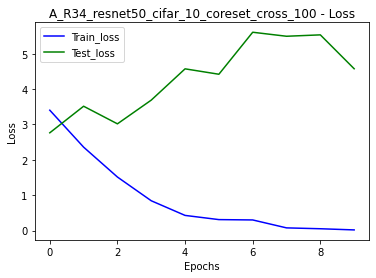

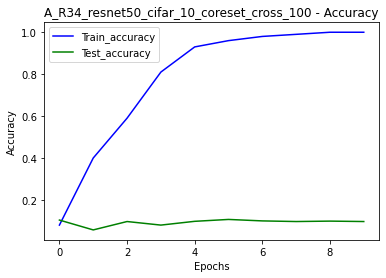

{'Victim': 'resnet50', 'Dataset': 'cifar_10', 'QueryType': 'coreset_cross', 'QuerySize': 100, 'Attacker': 'resnet34', 'Train Loss': 0.0169, 'Train Accuracy': 100.0, 'Test Loss': 4.5771, 'Test Accuracy': 9.7}
---------------------------------------------------------------------------
---------------------------------------------------------------------------


In [2]:
# Iterate through Model & Dataset
Results = []
for victim in parameters["victim"]:
    print('---------------------------------------------------------------------------')
    print(f'--------Victim: {victim["model_name"]} Dataset: {victim["data"]}------------')
    # Download and use dataset
    transform = torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor(),
         torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    if(victim["data"]==CIFAR_10):
        trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True, download=True, transform=transform)
        testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False, download=True, transform=transform)
    elif(victim["data"]==CIFAR_100):
        trainset = torchvision.datasets.CIFAR100(root='./cifar100', train=True, download=True, transform=transform)
        testset = torchvision.datasets.CIFAR100(root='./cifar100', train=False, download=True, transform=transform)
    else:
        print("Dataset not configured")

    # uplaod to data loader
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=config['batch_size'], shuffle=True)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=config['batch_size'], shuffle=False)
    
    # query test data
    querytestloader = QueryVictim(config["victim"], testloader, len(testloader.dataset))
    #querytestloader = QueryVictim(config["victim"], testloader, 1000)
    
    # Iterate Through Query Type
    for querytype in parameters["query_type"]:
        # Iterate Through Query Size
        for size in parameters["query_size"]:
            print('----------------------------------')
            print(f'---------------Query Type: {querytype} Query Size: {size}-------------------')
            # query train data
            querytrainloader = QueryVictim(victim, trainloader, size, sampling=querytype)
            # initialize attacker model
            attacker = ResNet34(3, ResBlock, outputs=10)
            attacker_loss = torch.nn.CrossEntropyLoss()
            # train attacker model
            attacker_result = Training(attacker, querytrainloader, querytestloader, (-1, 3, 32, 32), config["epochs"], optimizer=torch.optim.Adam(
                attacker.parameters(), lr=config["learning_rate"]), loss=attacker_loss)
            # save & visualize model inference
            percent = SaveVisualize(attacker, attacker_result, f'A_R34_{victim["model_name"]}_{victim["data"]}_{querytype}_{size}')
            results_dict={"Victim":victim["model_name"],
                            "Dataset":victim["data"],
                            "QueryType": querytype,
                            "QuerySize": size,
                            "Attacker": 'resnet34',
                            "Train Loss": percent[0],
                            "Train Accuracy": percent[1],
                            "Test Loss": percent[2],
                            "Test Accuracy": percent[3]}

            print(results_dict)
            Results.append(results_dict)
            print('---------------------------------------------------------------------------')
            print('---------------------------------------------------------------------------')


# Archived

Load querytestloader from file

In [ ]:
# load queried test data
querytestloader = torch.load(f'attacker/queried_data/{config["victim"]["data"]}_queriedtestdataloader.pt')
print(f'Input dataset:{len(testloader.dataset)}, Queried dataset:{len(querytestloader.dataset)}')

Testing Time outputs

In [ ]:
with torch.autograd.profiler.profile(use_cuda=True) as prof:
    qtl = QueryVictim(trainloader, 1000, sampling='coreset_cross')
print(f'Query Time:{prof.key_averages().self_cpu_time_total/1e6}s)

Visualize random Images from CIFAR-10

In [ ]:
class_names = ['air_plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# get some random training images
plt.figure(figsize=(10, 10))
counter = 0
for images, labels in trainloader:
    for i, img in enumerate(images):
        plt.subplot(5, 5, counter+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = img/2 + 0.5   # unmornalize
        # convert (C,H,W) to (H,W,C)
        img_show = np.transpose(img, (1, 2, 0))
        plt.imshow(img_show, cmap=plt.cm.binary)
        plt.xlabel(class_names[int(labels[i])], color='red', fontsize='large')
        counter += 1
        if counter == 25:
            break
    if counter == 25:
        break

plt.show()

Train a pseudo victim Model

In [ ]:
# create victim as resnet34
victim = ResNet34(3, ResBlock, outputs=10)
victim_loss = torch.nn.CrossEntropyLoss()

# train model
victim_result = Training(victim, trainloader, testloader, (-1, 3, 32, 32), config["epochs"], optimizer=torch.optim.Adam(
    victim.parameters(), lr=config["learning_rate"]), loss=victim_loss)

# save model inference
torch.save(victim.state_dict(), 'Victim_resnet34')

# visualization
plots(victim_result, 'Victim-resnet34')

Load Victim from File

In [ ]:
victim = ResNet34(3, ResBlock, outputs=10)
victim.load_state_dict(torch.load('Victim_resnet34'))
victim.eval()